<https://vincentarelbundock.github.io/rethinking2/04.html>

## Dataset

<https://en.wikipedia.org/wiki/%C7%83Kung_people>

<https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv>

In [46]:
import nest_asyncio
nest_asyncio.apply()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stan

In [62]:
plt.rcParams["figure.figsize"] = (8,6)

In [48]:
howell_df = pd.read_csv('../data/Howell1.csv', sep = ';')
howell_df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Modeling height

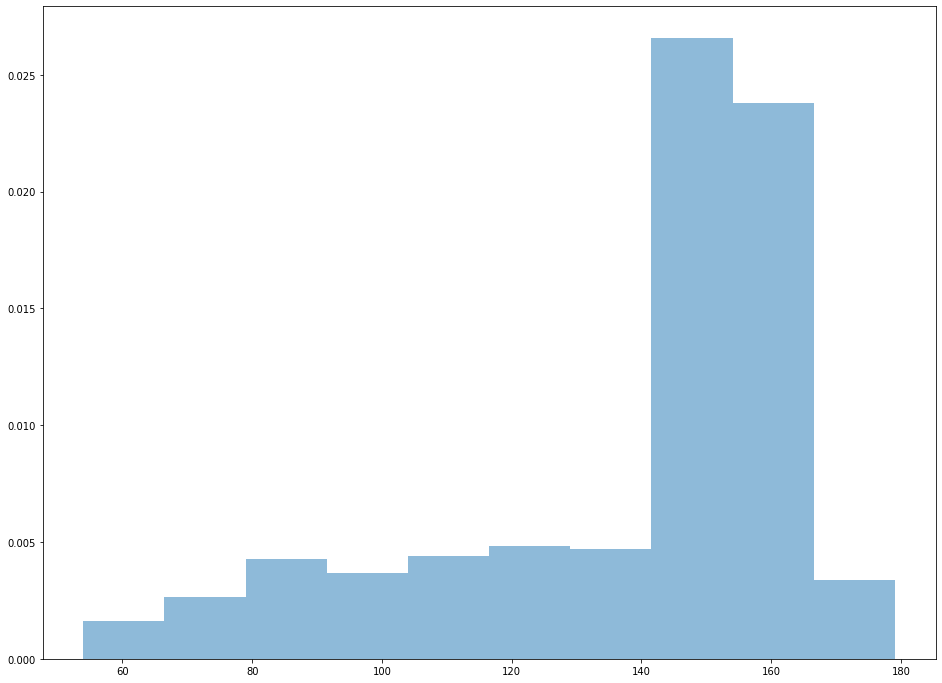

In [49]:
plt.hist(howell_df['height'], density=True, alpha=0.5)
plt.show()

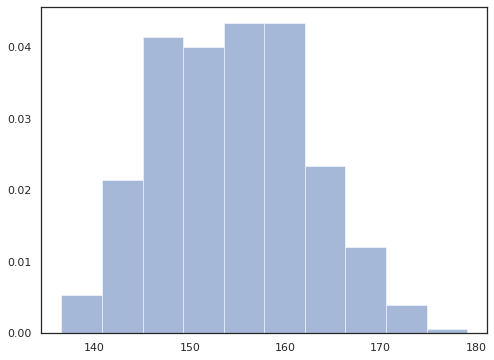

In [70]:
howell18_df = howell_df.query('age >= 18').copy()

plt.hist(howell18_df['height'], density=True, alpha=0.5)
plt.show()

In [71]:
howell_code = """
data {
  int<lower=1> n;
  vector[n] height;
}
parameters {
  real mu;
  real<lower=0,upper=50> sigma;
}
model {
  height ~ normal(mu, sigma);
  sigma ~ uniform(0, 50);
  mu ~ normal(178, 20);
}
"""

In [72]:

height_data = {
    'n': len(howell18_df),
    'height': list(howell18_df['height'])
}

In [5]:
posterior = stan.build(howell_code, data=height_data, random_seed=1)

Building...
Messages from stanc:
  Your Stan program has a parameter sigma with a lower and upper bound in its
  declaration. These hard constraints are not recommended, for two reasons:
  (a) Except when there are logical or physical constraints, it is very
  unusual for you to be sure that a parameter will fall inside a specified
  range, and (b) The infinite gradient induced by a hard constraint can cause
  difficulties for Stan's sampling algorithm. As a consequence, we recommend
  soft constraints rather than hard constraints; for example, instead of
  constraining an elasticity parameter to fall between 0, and 1, leave it
  unconstrained and give it a normal(0.5,0.5) prior distribution.
Warning at '/tmp/httpstan_25loe7e2/model_q3bsn3po.stan', line 12, column 21 to column 23:
  Argument 50 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Warning at '/tmp/httpstan_25loe7e2/model_q3bsn3po.stan', line 13, col

In [6]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling...
    0/8000 [>---------------------------]   0%  1 sec/0     
 8000/8000 [============================] 100%  1 sec/0   Messages received during sampling:
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!

 8000/8000 [============================] 100%  1 sec/0     
Done.


In [7]:
mus = fit["mu"]
sigmas = fit['sigma']
mus[0]

array([154.47479932, 155.00544503, 155.06111735, ..., 155.11116087,
       154.58224496, 155.49216258])

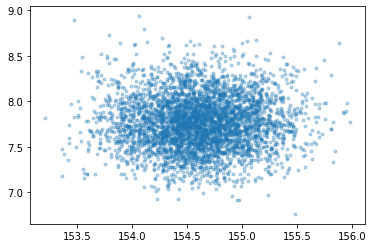

In [32]:
plt.plot(mus[0], sigmas[0], '.', alpha=0.3)
plt.show()

<https://github.com/aloctavodia/BAP/blob/master/first_edition/code/Chp1/hpd.py>

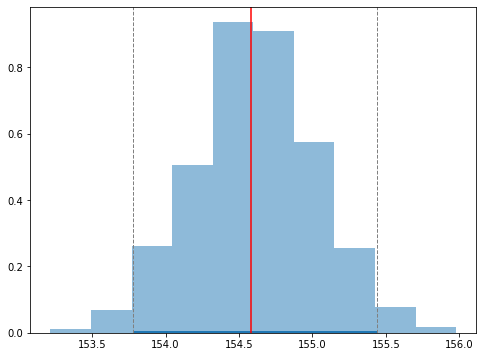

In [9]:
from hpd import hpd_grid

hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(mus[0])

plt.figure(figsize=(8,6))

plt.hist(mus[0], density=True, alpha=0.5)

for (x0, x1) in hpd_mu:
    plt.hlines(y=0, xmin=x0, xmax=x1, linewidth=5)
    plt.axvline(x=x0, color='grey', linestyle='--', linewidth=1)
    plt.axvline(x=x1, color='grey', linestyle='--', linewidth=1)

for xm in modes_mu:
    plt.axvline(x=xm, color='r')

plt.show()

## Height vs weight

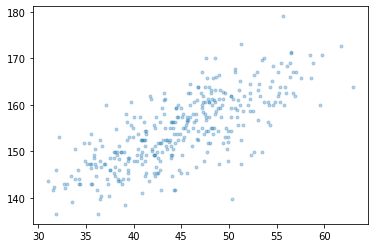

In [35]:
plt.plot(howell18_df['weight'], howell18_df['height'], '.', alpha=0.3)
plt.show()

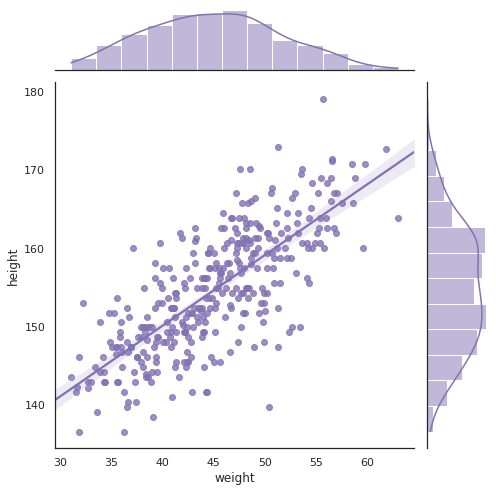

In [59]:
import seaborn as sns

sns.set_theme(style="white")

tips = sns.load_dataset("tips")
g = sns.jointplot(x="weight", y="height", data=howell18_df,
                  kind="reg", truncate=False,
                  color="m", height=7)

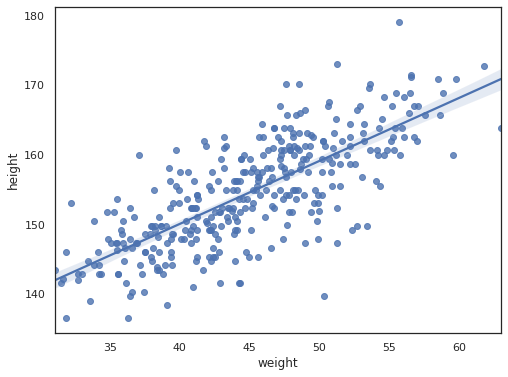

In [67]:
sns.regplot(x="weight", y="height", data=howell18_df);

In [18]:
howell_code2 = """
data {
  int<lower=1> n;
  real xbar;
  vector[n] height;
  vector[n] weight;
}
parameters {
  real<lower=0,upper=50> sigma;
  real<lower=0> b;
  real a;
}
model {
  vector[n] mu;
  mu = a + b * (weight - xbar);
  height ~ normal(mu, sigma);
  a ~ normal(178, 20);
  b ~ lognormal(0, 1);
  sigma ~ uniform(0, 50);
}
"""

In [19]:
height_data2 = {
    'n': len(howell18_df),
    'height': list(howell18_df['height']),
    'weight': list(howell18_df['weight']),
    'xbar': np.mean(howell18_df['weight'])
}

In [20]:
posterior2 = stan.build(howell_code2, data=height_data2, random_seed=1)

Building... This may take some time.
Messages from stanc:
  Your Stan program has a parameter sigma with a lower and upper bound in its
  declaration. These hard constraints are not recommended, for two reasons:
  (a) Except when there are logical or physical constraints, it is very
  unusual for you to be sure that a parameter will fall inside a specified
  range, and (b) The infinite gradient induced by a hard constraint can cause
  difficulties for Stan's sampling algorithm. As a consequence, we recommend
  soft constraints rather than hard constraints; for example, instead of
  constraining an elasticity parameter to fall between 0, and 1, leave it
  unconstrained and give it a normal(0.5,0.5) prior distribution.
Warning at '/tmp/httpstan_rrxdq20g/model_e4jzqoqn.stan', line 17, column 13 to column 16:
  Argument 178 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Warning at '/tmp/httpstan_rrxdq20g/model_e4

In [21]:
fit2 = posterior2.sample(num_chains=4, num_samples=1000)

Sampling...
    0/8000 [>---------------------------]   0%  1 sec/0     
 8000/8000 [============================] 100%  1 sec/0   Messages received during sampling:
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.88 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!

 8000/8000 [============================] 100%  1 sec/0     
Done.


In [91]:
len(fit2['a'][0])


4000

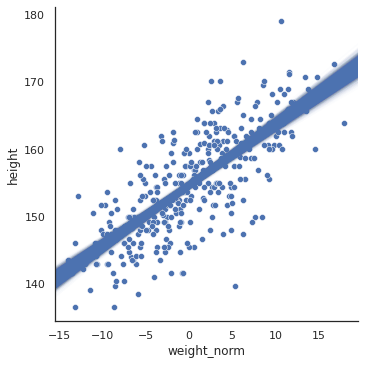

In [92]:
howell18_df['weight_norm'] = howell18_df['weight'] - np.mean(howell18_df['weight'])

graph = sns.relplot(x="weight_norm", y="height", data=howell18_df);
for i in range(len(fit2['a'][0])):
    plt.axline((0, fit2['a'][0][i]), slope=fit2['b'][0][i], alpha=.01)